Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [32]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [33]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [34]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [35]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [36]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [37]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [38]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [39]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [40]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

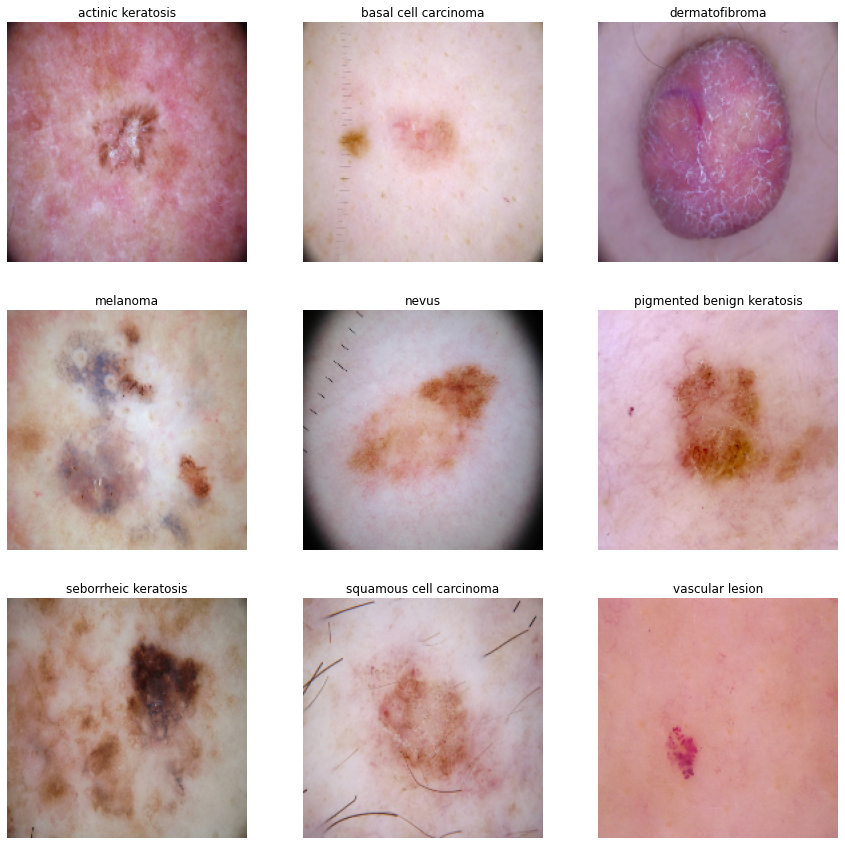

In [41]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15,15))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Let's now build the CNN architecture. 

We will build a network with:
- Two convolutional layers having 16 and 32 filters respectively, 
- followed by a max pooling layer, 
- Another convolution layer with 32 filters,
- followed by a max pooling layer,
- followed by dropout to regularize the model
- and then `Flatten` the output of the pooling layer to give us a long vector, 
- then add a fully connected `Dense` layer with 128 neurons, and finally
- add a `softmax` layer with 10 neurons

The generic way to build a model in Keras is to instantiate a `Sequential` model and keep adding `keras.layers` to it. We will also use some dropouts.

In [43]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [44]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      1216      
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      12832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Train the model

In [46]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 197s 3s/step - loss: 2.0408 - accuracy: 0.2271 - val_loss: 1.9543 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 3s 60ms/step - loss: 1.9026 - accuracy: 0.2852 - val_loss: 1.8009 - val_accuracy: 0.3289
Epoch 3/20
56/56 [==============================] - 3s 60ms/step - loss: 1.8503 - accuracy: 0.3158 - val_loss: 1.9486 - val_accuracy: 0.2819
Epoch 4/20
56/56 [==============================] - 3s 60ms/step - loss: 1.7506 - accuracy: 0.3516 - val_loss: 1.7690 - val_accuracy: 0.3311
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 1.6163 - accuracy: 0.4336 - val_loss: 1.5323 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 3s 59ms/step - loss: 1.4933 - accuracy: 0.4827 - val_loss: 1.5003 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 3s 60ms/step - loss: 1.4630 - accuracy: 0.4810 - val_loss: 1.5395 - val_accuracy: 0.4653
Epoch 8/20
56

### Visualizing training results

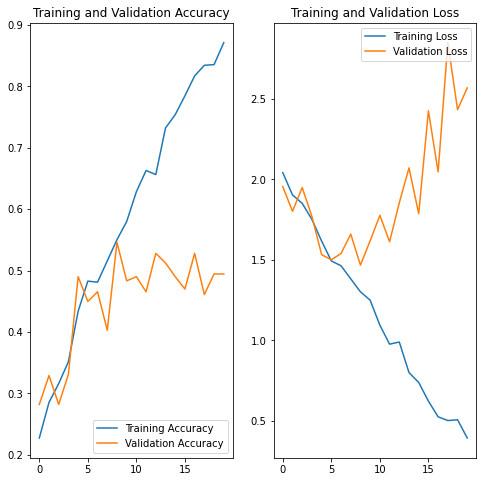

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- The Validation accuracy is far less than the Training Accuracy which is clear indication of Overfit of the model. Validation loss also increasing with the number of epoch. Certainly this model has lot of improvement

### Write your findings here

In [48]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.1),
    ]
)

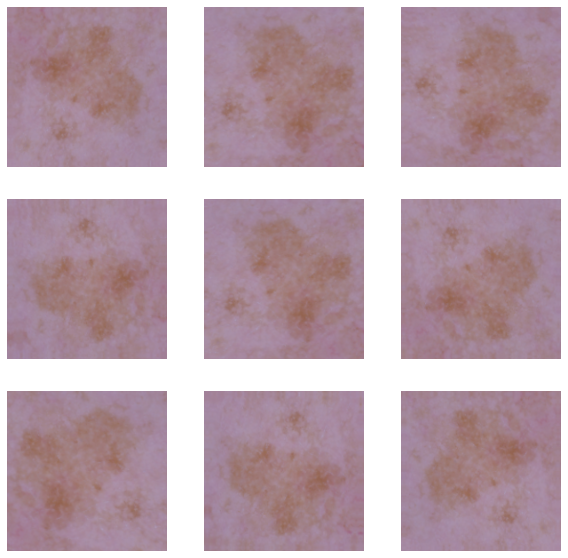

In [49]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [57]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [58]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [59]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 26ms/step - loss: 2.0744 - accuracy: 0.1975 - val_loss: 2.0095 - val_accuracy: 0.2237
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.9928 - accuracy: 0.2344 - val_loss: 1.8887 - val_accuracy: 0.3020
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9023 - accuracy: 0.2997 - val_loss: 1.7306 - val_accuracy: 0.3937
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6619 - accuracy: 0.4174 - val_loss: 1.6466 - val_accuracy: 0.4161
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5663 - accuracy: 0.4448 - val_loss: 1.5124 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5296 - accuracy: 0.4537 - val_loss: 1.4920 - val_accuracy: 0.4832
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4919 - accuracy: 0.4844 - val_loss: 1.4557 - val_accuracy: 0.4698
Epoch 8/20
56

### Visualizing the results

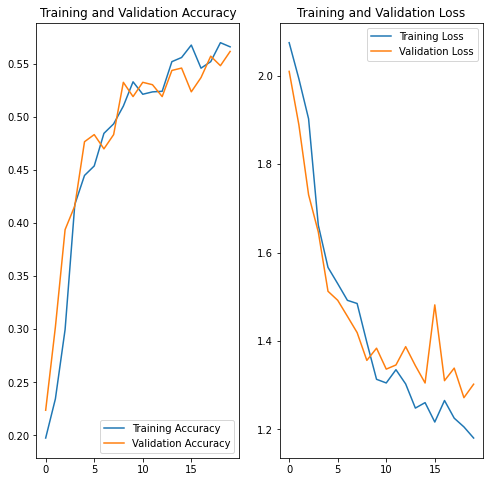

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

*Inference from Model 2:*

As we can see from the above graphs, the overfitting has been reduced effectively after inclusion of data augumentation and dropout layer. In the Acc graph, the gap between the training and validation acc has reduced significantly. And in the Loss graph, the gap between the training and validation loss functions have been reduced. The Training and Validation accuracy is almost equal.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [61]:
## Your code goes here.
from pathlib import Path

In [62]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis


114

In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma


376

In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma


95

In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma


438

In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus


357

In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis


462

In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis


77

In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma


181

In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion


139

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

`Answer: From the above counts, we can see this class "seborrheic keratosis" has least number of samples with 77 samples.`

#### - Which classes dominate the data in terms proportionate number of samples?

`Answer: From the above counts, we can see this class "pigmented benign keratosis" has high number of samples with 462`

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [63]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [64]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1B9A0C9FD0>: 100%|██████████| 500/500 [00:19<00:00, 25.57 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1B7CB85310>: 100%|██████████| 500/500 [00:21<00:00, 23.05 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1B7CD80ED0>: 100%|██████████| 500/500 [00:23<00:00, 21.46 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F1B7CAF0E90>: 100%|██████████| 500/500 [01:35<00:00,  5.26 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F1B7CBA9090>: 100%|██████████| 500/500 [01:27<00:00,  5.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1C8A904B90>: 100%|██████████| 500/500 [00:20<00:00, 24.81 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1C8E37D850>: 100%|██████████| 500/500 [00:41<00:00, 12.15 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1B84E999D0>: 100%|██████████| 500/500 [00:18<00:00, 27.45 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1B7CBD1290>: 100%|██████████| 500/500 [00:18<00:00, 26.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [70]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [69]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [71]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025302.jpg_5a60a5f5-7f18-4377-a3d5-b4f8e2284583.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029297.jpg_c1271e78-b44e-41ab-8f8c-b36cb167ebbe.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033860.jpg_14d78b32-8687-49c5-8cbc-7a7ccf51c0a6.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_6ce4b2b6-4f04-45b2-849d-94e60a8d8939.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027598.jpg_faa1c660-1089-4b6c-8833-d89d39df5367.jpg',


In [72]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
set(lesion_list_new)

{'actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion'}

In [73]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [74]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [75]:
df2['Label'].value_counts()

dermatofibroma                500
seborrheic keratosis          500
vascular lesion               500
squamous cell carcinoma       500
actinic keratosis             500
basal cell carcinoma          500
nevus                         500
pigmented benign keratosis    500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [76]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [77]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [78]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [79]:
## your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [80]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [81]:
epochs = 20
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 32s 182ms/step - loss: 1.8397 - accuracy: 0.3069 - val_loss: 1.5909 - val_accuracy: 0.4157
Epoch 2/30
169/169 [==============================] - 30s 170ms/step - loss: 1.3930 - accuracy: 0.4859 - val_loss: 1.3261 - val_accuracy: 0.5145
Epoch 3/30
169/169 [==============================] - 31s 177ms/step - loss: 1.1858 - accuracy: 0.5597 - val_loss: 1.2151 - val_accuracy: 0.5650
Epoch 4/30
169/169 [==============================] - 30s 174ms/step - loss: 0.9882 - accuracy: 0.6350 - val_loss: 1.0450 - val_accuracy: 0.6199
Epoch 5/30
169/169 [==============================] - 30s 173ms/step - loss: 0.7837 - accuracy: 0.7159 - val_loss: 1.2662 - val_accuracy: 0.5768
Epoch 6/30
169/169 [==============================] - 31s 176ms/step - loss: 0.6075 - accuracy: 0.7799 - val_loss: 0.9292 - val_accuracy: 0.7016
Epoch 7/30
169/169 [==============================] - 30s 174ms/step - loss: 0.5001 - accuracy: 0.8199 - val_loss: 0.7851 - val_ac

#### **Todo:**  Visualize the model results

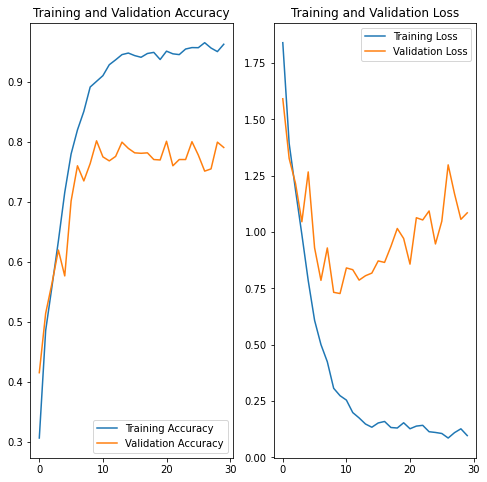

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1. We could see here that the training as well as the validation accuracy as well as the Loss has increased in a good amount keeping the gap more or less the same as the previous model. 
2. Dropouts has helped to reduce the overfitting
3. Class imbalance helped to improve the training and validation accuracy.